In [1]:
import sys
import os
sys.path.append('../')
import shap
import torch
import cv2
from torch.utils.data import DataLoader
from mri_dataset_combined_shap import MRI_Dataset, MRI_Dataset_combined
from torchvision.models.efficientnet import efficientnet_v2_l, efficientnet_v2_m
import numpy 
import torchvision
from combined_classifier_shap import *
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True
from custom_image_shap import image as image_plot
import seaborn as sns
import pandas as pd
from scipy.special import softmax
from datetime import datetime



In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8') 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#train_dataset = MRI_Dataset('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', transform=transform, slice= 12, orientation= 'AXIAL') 
train_dataset = MRI_Dataset_combined('/Users/olath/Documents/GitHub/Master-thesis/Datasets/train-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', device, slice= [12, 72, 43, 6, 58, 43])
val_dataset = MRI_Dataset_combined('/Users/olath/Documents/GitHub/Master-thesis/Datasets/val-CN-sMCI-pMCI-AD','/Users/olath/Documents/ADNI_SLICED_RESCALED/', device, slice= [12, 72, 43, 6, 58, 43])

#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_loader  = DataLoader(train_dataset, batch_size=512, shuffle=True)
validation_loader  = DataLoader(val_dataset, batch_size=1071, shuffle=True)

#X, y = validation_loader()

In [4]:
#device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#device = 'cpu'

#axial = efficientnet_v2_l(num_classes = 4)
#axial.load_state_dict(torch.load('/Users/olath/Downloads/model_12AXIAL_202503010344_best.pth', weights_only=True, map_location=torch.device('mps')))
#sagittal = efficientnet_v2_l(num_classes = 4)
#sagittal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_72SAGITTAL_202502281601_best.pth', weights_only=True, map_location=torch.device('cuda')))
#coronal = efficientnet_v2_l(num_classes = 4)
#coronal.load_state_dict(torch.load('/fp/homes01/u01/ec-olathor/Documents/thesis/model_44CORONAL_202502280117_best.pth', weights_only=True, map_location=torch.device('cuda')))
#axial.eval()
#sagittal.eval()
#coronal.eval()  

axial1 = efficientnet_v2_m(num_classes = 3)
sagittal1 = efficientnet_v2_m(num_classes = 3)
coronal1 = efficientnet_v2_m(num_classes = 3)
axial2 = efficientnet_v2_m(num_classes = 2)
sagittal2 = efficientnet_v2_m(num_classes = 2)
coronal2 = efficientnet_v2_m(num_classes = 2)

#model = CombinedClassifierLogReg(4, axial, sagittal, coronal, device, dropout= 0.8, num_outputs = 1000)
#model.load_state_dict(torch.load('/Users/olath/Downloads/model_4class_202503071431_best.pth', weights_only=True, map_location=torch.device('mps'))
model = DoubleCombinedClassifierLogReg(4, axial1, sagittal1, coronal1, axial2, sagittal2, coronal2, device, dropout = 0.4, num_outputs = 250)
model.load_state_dict(torch.load('/Users/olath/Downloads/model_4classDouble_202503171605_best.pth', weights_only=True, map_location=torch.device('mps')))
model.to(device)
model.eval()

DoubleCombinedClassifierLogReg(
  (axial_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [5]:
def f(x):
    x = torch.from_numpy(x)
    #x = torch.clone(x)
    #x = torch.permute(x,(0, 3, 1, 2))
    return torch.softmax(model(x.to(device)), 1)


In [ ]:
X, y = next(iter(validation_loader))
#X = X.to(device)

out = model(X[0], X[1], X[2], X[3], X[4], X[5])

best_pred = 0
best_pred_index = 0

means = np.empty(len(out))
best = list()
scores = list()
best_dict = {}

label_wanted = 0
label_true = 0
for j in range (0, 1):
    out = model(X[0], X[1], X[2], X[3], X[4], X[5])
    for i in range(0, len(out)):
        means[i] = out[i].cpu().detach().numpy().mean()
        if y[i] == label_true and (out[i].max() == out[i][label_wanted]):
            best_dict[out[i][label_wanted].cpu().detach().item()] = i
            scores.append(out[i][label_wanted].cpu().detach().item())
            if out[i][label_wanted] > best_pred:
                best_pred = out[i][label_wanted]
                best_pred_index = i
                #best.append([X[0][best_pred_index].cpu().detach(), X[1][best_pred_index].cpu().detach(), X[2][best_pred_index].cpu().detach(), 
                #X[3][best_pred_index].cpu().detach(), X[4][best_pred_index].cpu().detach(), X[5][best_pred_index].cpu().detach()])
    out = model(X[0], X[1], X[2], X[3], X[4], X[5])

scores.sort()

print(len(scores))
    
for score in scores:
    best.append([X[0][best_dict[score]].cpu().detach(), X[1][best_dict[score]].cpu().detach(), X[2][best_dict[score]].cpu().detach(), 
            X[3][best_dict[score]].cpu().detach(), X[4][best_dict[score]].cpu().detach(), X[5][best_dict[score]].cpu().detach()])

out = model(X[0][best_pred_index:best_pred_index+1], X[1][best_pred_index:best_pred_index+1], X[2][best_pred_index:best_pred_index+1], 
            X[3][best_pred_index:best_pred_index+1], X[4][best_pred_index:best_pred_index+1], X[5][best_pred_index:best_pred_index+1])

out = out.cpu().detach().numpy().mean()

best_pred = best_pred.cpu().detach().numpy().round(4)


In [7]:
y_num = y[best_pred_index:best_pred_index+1].numpy()

just_labels = {0: 'CN', 1:'sMCI',2:'pMCI',3:'AD'}

labels = {0: 'True class: CN\nPredicted: ' +str(just_labels[label_wanted]), 1:'True class: sMCI\nPredicted: ' +str(just_labels[label_wanted]), 2: 'True class: pMCI\nPredicted: ' +str(just_labels[label_wanted]), 3:'True class: AD\nPredicted: ' +str(just_labels[label_wanted])}
true_labels = list()

for  label in y_num:    

    true_labels.append(labels[label])

In [ ]:
X_train, y_train = next(iter(train_loader))

best = np.array(best)

best_input = np.transpose(best[-3:], (1, 0, 2, 3, 4)).tolist()

for i in range(0, len(best_input)):
    best_input[i] = torch.tensor(best_input[i]).to(device)
    
explainer = shap.GradientExplainer(model, X_train, batch_size= 16)

shap_values, shap_values_var = explainer.shap_values(best_input, nsamples = 20, return_variances= True)

In [ ]:
plot_path = '/Users/olath/Documents'

plot_pred = model(X[0][best_pred_index:best_pred_index+1], X[1][best_pred_index:best_pred_index+1], X[2][best_pred_index:best_pred_index+1], 
            X[3][best_pred_index:best_pred_index+1], X[4][best_pred_index:best_pred_index+1], X[5][best_pred_index:best_pred_index+1])

plot_pred = plot_pred.cpu().detach().numpy()

plot_pred = plot_pred[0].round(4)


def plot_shap_images(X, shap_values, true_labels, plot_pred, plot_path):

    display_img1 = torch.permute(X[0][0].cpu(), (1, 2, 0)).numpy()
    display_img2 = torch.permute(X[1][0].cpu(), (1, 2, 0)).numpy()
    display_img3 = torch.permute(X[2][0].cpu(), (1, 2, 0)).numpy()
    display_img4 = torch.permute(X[3][0].cpu(), (1, 2, 0)).numpy()
    display_img5 = torch.permute(X[4][0].cpu(), (1, 2, 0)).numpy()
    display_img6 = torch.permute(X[5][0].cpu(), (1, 2, 0)).numpy()

    display_val1 = np.transpose(shap_values[0], (4, 0, 2, 3, 1))
    display_val2 = np.transpose(shap_values[1], (4, 0, 2, 3, 1))
    display_val3 = np.transpose(shap_values[2], (4, 0, 2, 3, 1))
    display_val4 = np.transpose(shap_values[3], (4, 0, 2, 3, 1))
    display_val5 = np.transpose(shap_values[4], (4, 0, 2, 3, 1))
    display_val6 = np.transpose(shap_values[5], (4, 0, 2, 3, 1))
    [12, 72, 43, 6, 58, 43]
    image_plot([display_val1[i][-1] for i in range(4)], display_img1, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Axial - Slice: 12 - Classifier: CN/MCI/AD - Predicted probabilities: " + str(plot_pred))

    experiment_tag = '_'.join(['shap_image_input1', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 
    
    image_plot([display_val2[i][-1] for i in range(4)], display_img2, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Sagittal - Slice: 72 - Classifier: CN/MCI/AD - Predicted probabilities: " + str(plot_pred))
    
    experiment_tag = '_'.join(['shap_image_input2', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 
    
    image_plot([display_val3[i][-1] for i in range(4)], display_img3, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Coronal - Slice: 43 - Classifier: CN/MCI/AD - Predicted probabilities: " + str(plot_pred))
    
    experiment_tag = '_'.join(['shap_image_input3', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 
    
    image_plot([display_val4[i][-1] for i in range(4)], display_img4, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Axial - Slice: 06 - Classifier: sMCI/pMCI - Predicted probabilities: " + str(plot_pred))
    
    experiment_tag = '_'.join(['shap_image_input4', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 

    image_plot([display_val5[i][-1] for i in range(4)], display_img5, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Sagittal - Slice: 58 - Classifier: sMCI/pMCI - Predicted probabilities: " + str(plot_pred))
    
    experiment_tag = '_'.join(['shap_image_input5', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 
    
    image_plot([display_val6[i][-1] for i in range(4)], display_img6, show = False, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels, title = "Orientation: Coronal - Slice: 12 - Classifier: sMCI/pMCI - Predicted probabilities: " + str(plot_pred))

    experiment_tag = '_'.join(['shap_image_input6', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 


plot_shap_images(X, shap_values, plot_pred, plot_path)

NameError: name 'model' is not defined

In [ ]:
plot_path = '/Users/olath/Documents'

plot_pred = model(X[0][best_pred_index:best_pred_index+1], X[1][best_pred_index:best_pred_index+1], X[2][best_pred_index:best_pred_index+1], 
            X[3][best_pred_index:best_pred_index+1], X[4][best_pred_index:best_pred_index+1], X[5][best_pred_index:best_pred_index+1])

plot_pred = plot_pred.cpu().detach().numpy()

plot_pred = plot_pred[0].round(4)

def plot_bargraph(shap_values, plot_pred, predicted_class, true_class, plot_path, image_index = -1, fig_size = (8,8), palette = None):

    category_names = ['CN: ('+str(plot_pred[0].round(4))+')', 'sMCI: ('+str(plot_pred[1].round(4))+')', 'pMCI: ('+str(plot_pred[2].round(4))+')','AD: ('+str(plot_pred[3].round(4))+')']

    if predicted_class == true_class:
        choice = 'correctly'
    else:
        choice = 'wrongly'

    value_axial = np.transpose(shap_values[0][image_index], (3 ,0, 1, 2))
    value_sagittal = np.transpose(shap_values[1][image_index], (3 ,0, 1, 2))
    value_coronal = np.transpose(shap_values[2][image_index], (3 ,0, 1, 2))
    value_axial2 = np.transpose(shap_values[3][image_index], (3 ,0, 1, 2))
    value_sagittal2 = np.transpose(shap_values[4][image_index], (3 ,0, 1, 2))
    value_coronal2 = np.transpose(shap_values[5][image_index], (3 ,0, 1, 2))

    fig, ax = plt.subplots(figsize = (fig_size))
    sns.set_theme(palette)

    predicted_class_label = {0: 'a CN', 1: 'an sMCI', 2:'a pMCI', 3:'an AD'}

    labels = ('Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)')
    
    y_pos = np.arange(len(labels))

    sum_performance = [value_axial[0].sum().round(4),value_sagittal[0].sum().round(4),value_coronal[0].sum().round(4),
                value_axial2[0].sum().round(4),value_sagittal2[0].sum().round(4),value_coronal2[0].sum().round(4),
                value_axial[1].sum().round(4),value_sagittal[1].sum().round(4),value_coronal[1].sum().round(4),
                value_axial2[1].sum().round(4),value_sagittal2[1].sum().round(4),value_coronal2[1].sum().round(4),
                value_axial[2].sum().round(4),value_sagittal[2].sum().round(4),value_coronal[2].sum().round(4),
                value_axial2[2].sum().round(4),value_sagittal2[2].sum().round(4),value_coronal2[2].sum().round(4),
                value_axial[3].sum().round(4),value_sagittal[3].sum().round(4),value_coronal[3].sum().round(4),
                value_axial2[3].sum().round(4),value_sagittal2[3].sum().round(4),value_coronal2[3].sum().round(4)]

    ax.barh(y_pos[0:6], sum_performance[0:6], align='center', label = category_names[0])
    ax.barh(y_pos[6:12], sum_performance[6:12], align='center', label = category_names[1])
    ax.barh(y_pos[12:18], sum_performance[12:18], align='center', label = category_names[2])
    ax.barh(y_pos[18:24], sum_performance[18:24], align='center', label = category_names[3])

    ax.set_yticks(y_pos, labels=labels)
    ax.legend(ncols=1, fontsize='small', title = 'Predicted probabilities')
    ax.invert_yaxis()  
    ax.axvline(color="grey", alpha = 0.5)
    ax.set_xlabel('SHAP value')
    ax.set_ylabel('Orientation / Slice (Classifier)')
    ax.set_title('Sum of contributions of separate orientations to all model outputs\n for ' +str(predicted_class_label[true_class])+ ' patient ' + choice + ' classified as ' +str(predicted_class_label[predicted_class])+' patient' )

    experiment_tag = '_'.join(['shap_bar', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 

plot_bargraph(shap_values, plot_pred, label_wanted, label_true, plot_path, image_index = -1, fig_size = (8,8), palette = None)





[0.0318 0.0501 0.9569 0.9266]


In [ ]:

plot_path = '/Users/olath/Documents'

mean_pred = model(best_input[0],best_input[1],best_input[2],best_input[3],best_input[4],best_input[5]).detach().cpu().numpy()

pred_means = [mean_pred[:,0].mean(),mean_pred[:,1].mean(),mean_pred[:,2].mean(),mean_pred[:,3].mean()]

def plot_stripplot(shap_values, plot_pred, predicted_class, true_class, plot_path, num_images = 20, fig_size = (8,8), palette = None):

    fig, ax = plt.subplots(figsize = fig_size)
    sns.set_theme()

    if predicted_class == true_class:
        choice = 'correctly'
    else:
        choice = 'wrongly'

    labels = ('Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)')
    
    y_pos = np.arange(len(labels))

    predicted_class_label = {0: 'CN', 1: 'sMCI', 2:'pMCI', 3:'AD'}

    y_pos_jitter = [None]*24
    y_label_jitter = ['CN: ('+str(plot_pred[0].round(4))+')', 'sMCI: ('+str(plot_pred[1].round(4))+')', 'pMCI: ('+str(plot_pred[2].round(4))+')','AD: ('+str(plot_pred[3].round(4))+')']
    y_label_jitter = np.repeat(y_label_jitter, 6*num_images)

    for i in range(0, 24):

        y_pos_jitter[i] = np.repeat(y_pos[i], num_images)

    jitter_value_axial = np.transpose(shap_values[0], (0, 4 ,1, 2, 3))
    jitter_value_sagittal = np.transpose(shap_values[1], (0, 4 ,1, 2, 3))
    jitter_value_coronal = np.transpose(shap_values[2], (0, 4 ,1, 2, 3))
    jitter_value_axial2 = np.transpose(shap_values[3], (0, 4 ,1, 2, 3))
    jitter_value_sagittal2 = np.transpose(shap_values[4], (0, 4 ,1, 2, 3))
    jitter_value_coronal2 = np.transpose(shap_values[5], (0, 4 ,1, 2, 3))


    jitter_performance = [jitter_value_axial[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1)]

    data=pd.DataFrame({'col1': np.array(jitter_performance).flatten(), 'col2': np.array(y_pos_jitter).flatten(), 'col3' : y_label_jitter})

    sns.stripplot(x='col1', y='col2', data=data, hue = 'col3', palette=sns.color_palette(palette), orient = 'h')
    ax.set_yticks(y_pos, labels=labels)
    ax.legend(ncols=1, fontsize='small', title = 'Mean predicted probabilities')
    ax.axvline(color="grey",  alpha = 0.5)
    ax.grid(visible = True)
    ax.set_xlabel('SHAP value')
    ax.set_ylabel('Orientation / Slice (Classifier)')
    ax.set_title('Sums of input contributions to all model outputs\n for ' + str(num_images) + ' ' +str(predicted_class_label[true_class])+ ' patients ' + choice + ' classified as ' +str(predicted_class_label[predicted_class])+' patients')

    experiment_tag = '_'.join(['shap_strip', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 

plot_stripplot(shap_values, pred_means, label_wanted, label_true, plot_path, num_images = 3, fig_size = (8,8), palette = None)



/var/folders/vw/z90l8cxj075f6rjz06wn3hzc0000gn/T/ipykernel_75492/2948349005.py:69: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.stripplot(x='col1', y='col2', data=data, hue = 'col3', palette=sns.color_palette(palette), orient = 'h')


In [ ]:
def plot_extraplots(shap_values, predicted_class, true_class, plot_path, num_images = 20, fig_size = (8,18)):


    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = fig_size)

    np.random.seed(19680801)

    predicted_class_label = {0: 'CN', 1: 'sMCI', 2:'pMCI', 3:'AD'}

    if predicted_class == true_class:
        choice = 'correctly'
    else:
        choice = 'wrongly'

    labels = ('Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)',
            'Axial / 12 (CN/MCI/AD)', 'Sagittal / 72 (CN/MCI/AD)', 'Coronal / 43 (CN/MCI/AD)','Axial / 06  (sMCI/pMCI)', 'Sagittal / 58  (sMCI/pMCI)', 'Coronal / 43  (sMCI/pMCI)')

    jitter_value_axial = np.transpose(shap_values[0], (0, 4 ,1, 2, 3))
    jitter_value_sagittal = np.transpose(shap_values[1], (0, 4 ,1, 2, 3))
    jitter_value_coronal = np.transpose(shap_values[2], (0, 4 ,1, 2, 3))
    jitter_value_axial2 = np.transpose(shap_values[3], (0, 4 ,1, 2, 3))
    jitter_value_sagittal2 = np.transpose(shap_values[4], (0, 4 ,1, 2, 3))
    jitter_value_coronal2 = np.transpose(shap_values[5], (0, 4 ,1, 2, 3))


    jitter_performance = [jitter_value_axial[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,0].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,1].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,2].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1), 
                        jitter_value_sagittal[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_axial2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_sagittal2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1),
                        jitter_value_coronal2[:,3].sum(axis = 1).sum(axis = 1).sum(axis = 1)]

    all_data =  jitter_performance


    # plot violin plot
    axs[0].axvline(color="grey", alpha = 0.5)
    axs[0].violinplot(all_data, showmeans=False, showmedians=True, vert = False)
    axs[0].set_title('Sums of input contributions to all model outputs\n for ' + str(num_images) + ' ' +str(predicted_class_label[true_class])+ ' patients ' + choice + ' classified as ' +str(predicted_class_label[predicted_class])+' patients')

    # plot box plot
    axs[1].axvline(color="grey", alpha = 0.5)
    axs[1].boxplot(all_data, vert = False)
    axs[1].set_title('Sums of input contributions to all model outputs\n for ' + str(num_images) + ' ' +str(predicted_class_label[true_class])+ ' patients ' + choice + ' classified as ' +str(predicted_class_label[predicted_class])+' patients')

    # adding horizontal grid lines
    for ax in axs:
        ax.yaxis.grid(True)
        ax.set_yticks([y + 1 for y in range(len(all_data))],
                    labels=labels)
        ax.set_xlabel('SHAP values')
        ax.set_ylabel('Orientation / Slice (Classifier)')
        ax.invert_yaxis()

    experiment_tag = '_'.join(['shap_extraplots', datetime.now().strftime("%Y%m%d%H%M")])
    plot_save_path = os.path.join(plot_path, f'plot_{experiment_tag}.pdf')

    plt.savefig(plot_save_path, dpi = 1200, bbox_inches='tight')
    plt.close() 


plot_extraplots(shap_values, label_wanted, label_true, plot_path, num_images = 10, fig_size = (8,18))

In [ ]:
#print(len(shap_values))
print(len(shap_values_var))
print(len(shap_values_var[0]))
print(shap_values_var[0][0].shape)

display_img1 = torch.permute(X[0][0].cpu(), (1, 2, 0)).numpy()
display_img2 = torch.permute(X[1][0].cpu(), (1, 2, 0)).numpy()
display_img3 = torch.permute(X[2][0].cpu(), (1, 2, 0)).numpy()
display_img4 = torch.permute(X[3][0].cpu(), (1, 2, 0)).numpy()
display_img5 = torch.permute(X[4][0].cpu(), (1, 2, 0)).numpy()
display_img6 = torch.permute(X[5][0].cpu(), (1, 2, 0)).numpy()

display_val1 = np.transpose(shap_values_var[0], (4, 0, 2, 3, 1))
display_val2 = np.transpose(shap_values_var[1], (4, 0, 2, 3, 1))
display_val3 = np.transpose(shap_values_var[2], (4, 0, 2, 3, 1))
display_val4 = np.transpose(shap_values_var[3], (4, 0, 2, 3, 1))
display_val5 = np.transpose(shap_values_var[4], (4, 0, 2, 3, 1))
display_val6 = np.transpose(shap_values_var[5], (4, 0, 2, 3, 1))


image_plot([shap_values_var[i][0][0].transpose(1, 2, 0) for i in range(4)], display_img1, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][1][0].transpose(1, 2, 0) for i in range(4)], display_img2, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][2][0].transpose(1, 2, 0) for i in range(4)], display_img3, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][3][0].transpose(1, 2, 0) for i in range(4)], display_img4, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][4][0].transpose(1, 2, 0) for i in range(4)], display_img5, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)
image_plot([shap_values_var[i][5][0].transpose(1, 2, 0) for i in range(4)], display_img6, labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'], true_labels = true_labels)

4
6
(10, 3, 100, 100)


IndexError: list index out of range

Text(0.5, 1.0, 'Contributions of each orientation on the predicted probability of each class')

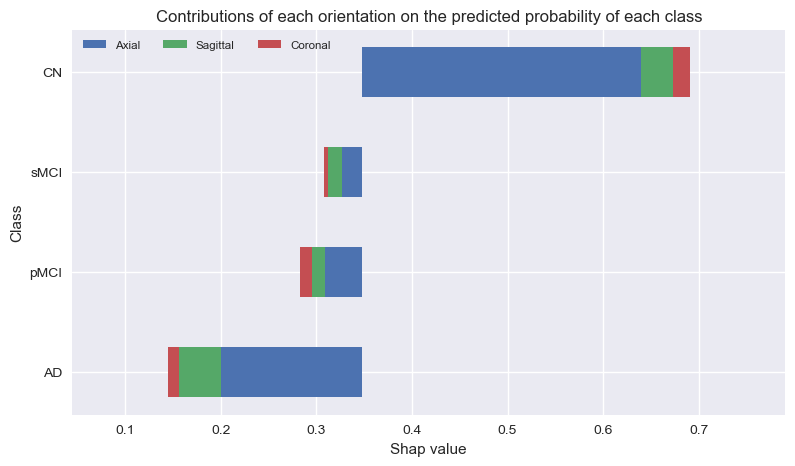

In [ ]:
category_names = ['Axial', 'Sagittal', 'Coronal']
results = {'CN': [value_axial[0].sum().round(4),value_sagittal[0].sum().round(4),value_coronal[0].sum().round(4)],
          'sMCI': [value_axial[1].sum().round(4),value_sagittal[1].sum().round(4),value_coronal[1].sum().round(4)],
          'pMCI': [value_axial[2].sum().round(4),value_sagittal[2].sum().round(4),value_coronal[2].sum().round(4)],
          'AD': [value_axial[3].sum().round(4),value_sagittal[3].sum().round(4),value_coronal[3].sum().round(4)]}

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.colormaps['RdYlGn'](
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(True)
ax.set_xlim(np.sum(data, axis=1).min()-0.1 + out, np.sum(data, axis=1).max()+0.1 + out)

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i] 
    starts = data_cum[:, i] - widths + out
    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=colname)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    #ax.bar_label(rects, label_type='center', color=text_color)
ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
        loc='upper left', fontsize='small')

ax.set_xlabel('Shap value')
ax.set_ylabel('Class')
ax.set_title('Contributions of each orientation on the predicted probability of each class')

In [ ]:
# Prepare data transformation pipeline
                        
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * numpy.array(mean) / numpy.array(std)).tolist(),
        std=(1 / numpy.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [ ]:
shap_values_data = inv_transform(shap_values.data).cpu().numpy()
shap_values_values = [val for val in numpy.moveaxis(shap_values.values, -1, 0)]


AttributeError: 'list' object has no attribute 'data'

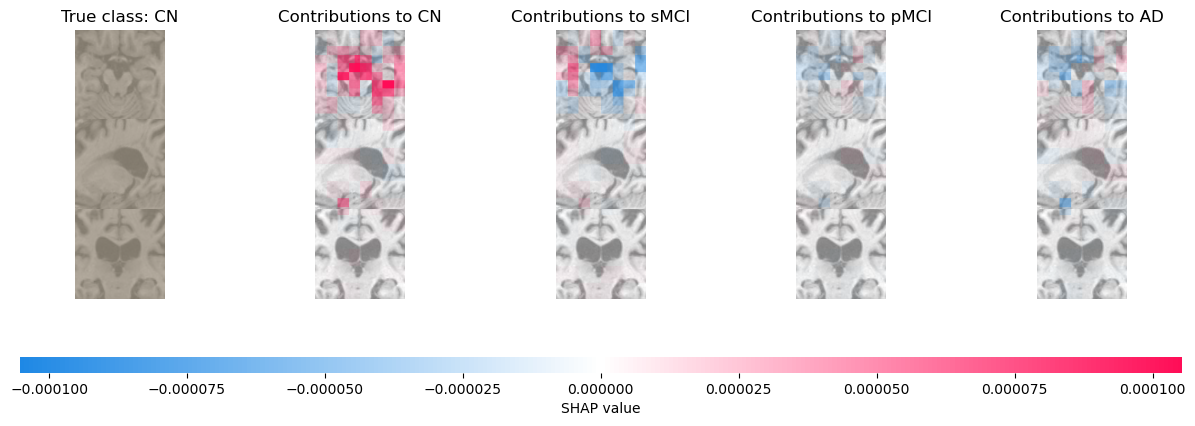

In [ ]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=shap_values_data,
    labels = ['Contributions to CN', 'Contributions to sMCI', 'Contributions to pMCI', 'Contributions to AD'],
    true_labels = true_labels,
    show = False
)

plt.savefig("test.png", dpi = 1200) 

In [ ]:
values = shap_values.values
data = shap_values.data

In [ ]:
data_num = data.numpy()
data_scaled = data_num/data_num.max()
values2 = values + 2626.385322093757
values_scaled = values2/values2.max()
print(data_scaled.max())
print(values_scaled.max())

1.0
1.0


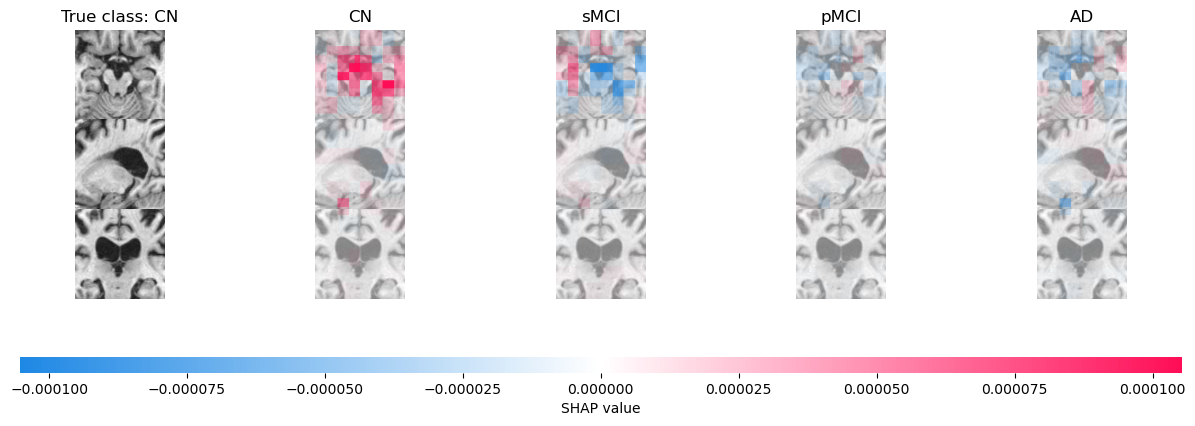

In [ ]:
image_plot(
    shap_values=shap_values_values,
    pixel_values=data_scaled,
    labels = ['CN', 'sMCI', 'pMCI', 'AD'],
    true_labels = true_labels
)

In [ ]:
test = shap_values.values[0]
test.shape
test2 = test.reshape(4, 3, 300, 100)
test3 = shap_values_values[0][0].reshape(3, 100, 100, 3)
print(shap_values_values[0].sum())
print(shap_values_values[1].sum())
print(shap_values_values[2].sum())
print(shap_values_values[3].sum())

print(shap_values_values[0].sum()-shap_values_values[1].sum()-shap_values_values[2].sum()-shap_values_values[3].sum())

0.21183383464813232
-0.07443493604660037
-0.05520151555538178
-0.08219747245311737
0.4236677587032318


In [ ]:
arr = numpy.array([0.45553565,0.18600965,0.17938341,0.17907123])
shap_values_values[1].sum() + arr.mean()


0.17556504895339964